# Design and test a lowpass filter

This document describes how to design a lowpass filter with a cutoff frequency $\omega_c$ and compute the discrete coefficients so that it can be implemented on hardware.

In [138]:
# Packages and adjustments to the figures
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import math
# import librosa
# import librosa.display

from IPython.display import Video
import IPython.display       as ipd
from   scipy.io     import wavfile

plt.style.use("../../assets/matplotlib_styles/pepso_light.mplstyle")
# plt.rcParams["figure.figsize"] = 10,5
# plt.rcParams["font.size"] = 16
# plt.rcParams.update({"text.usetex": True,"font.family": "sans-serif","font.sans-serif": ["Helvetica"]})

## 1. Generate a test signal
 
* A simple test signal $\boldsymbol{y} = \{ y_i \}$ is generated with a fixed sampling frequency using the function:

$$y(t) = m_0 \sin(2\pi f_0 t) + m_1 \sin(2\pi f_1 t)$$

* The power spectrum is plotted as the magnitude of the discrete fourier transform (DFT): $|\hat{\boldsymbol{y}}|$

### NOISY LIMIT SWITCH SINGAL

In [237]:
Video("../../assets/videos/flipper_limit_switch.mp4")

In [238]:
# Generate a signal
sampling_Freq = 1000; # sampled at 1 kHz = 1000 samples / second

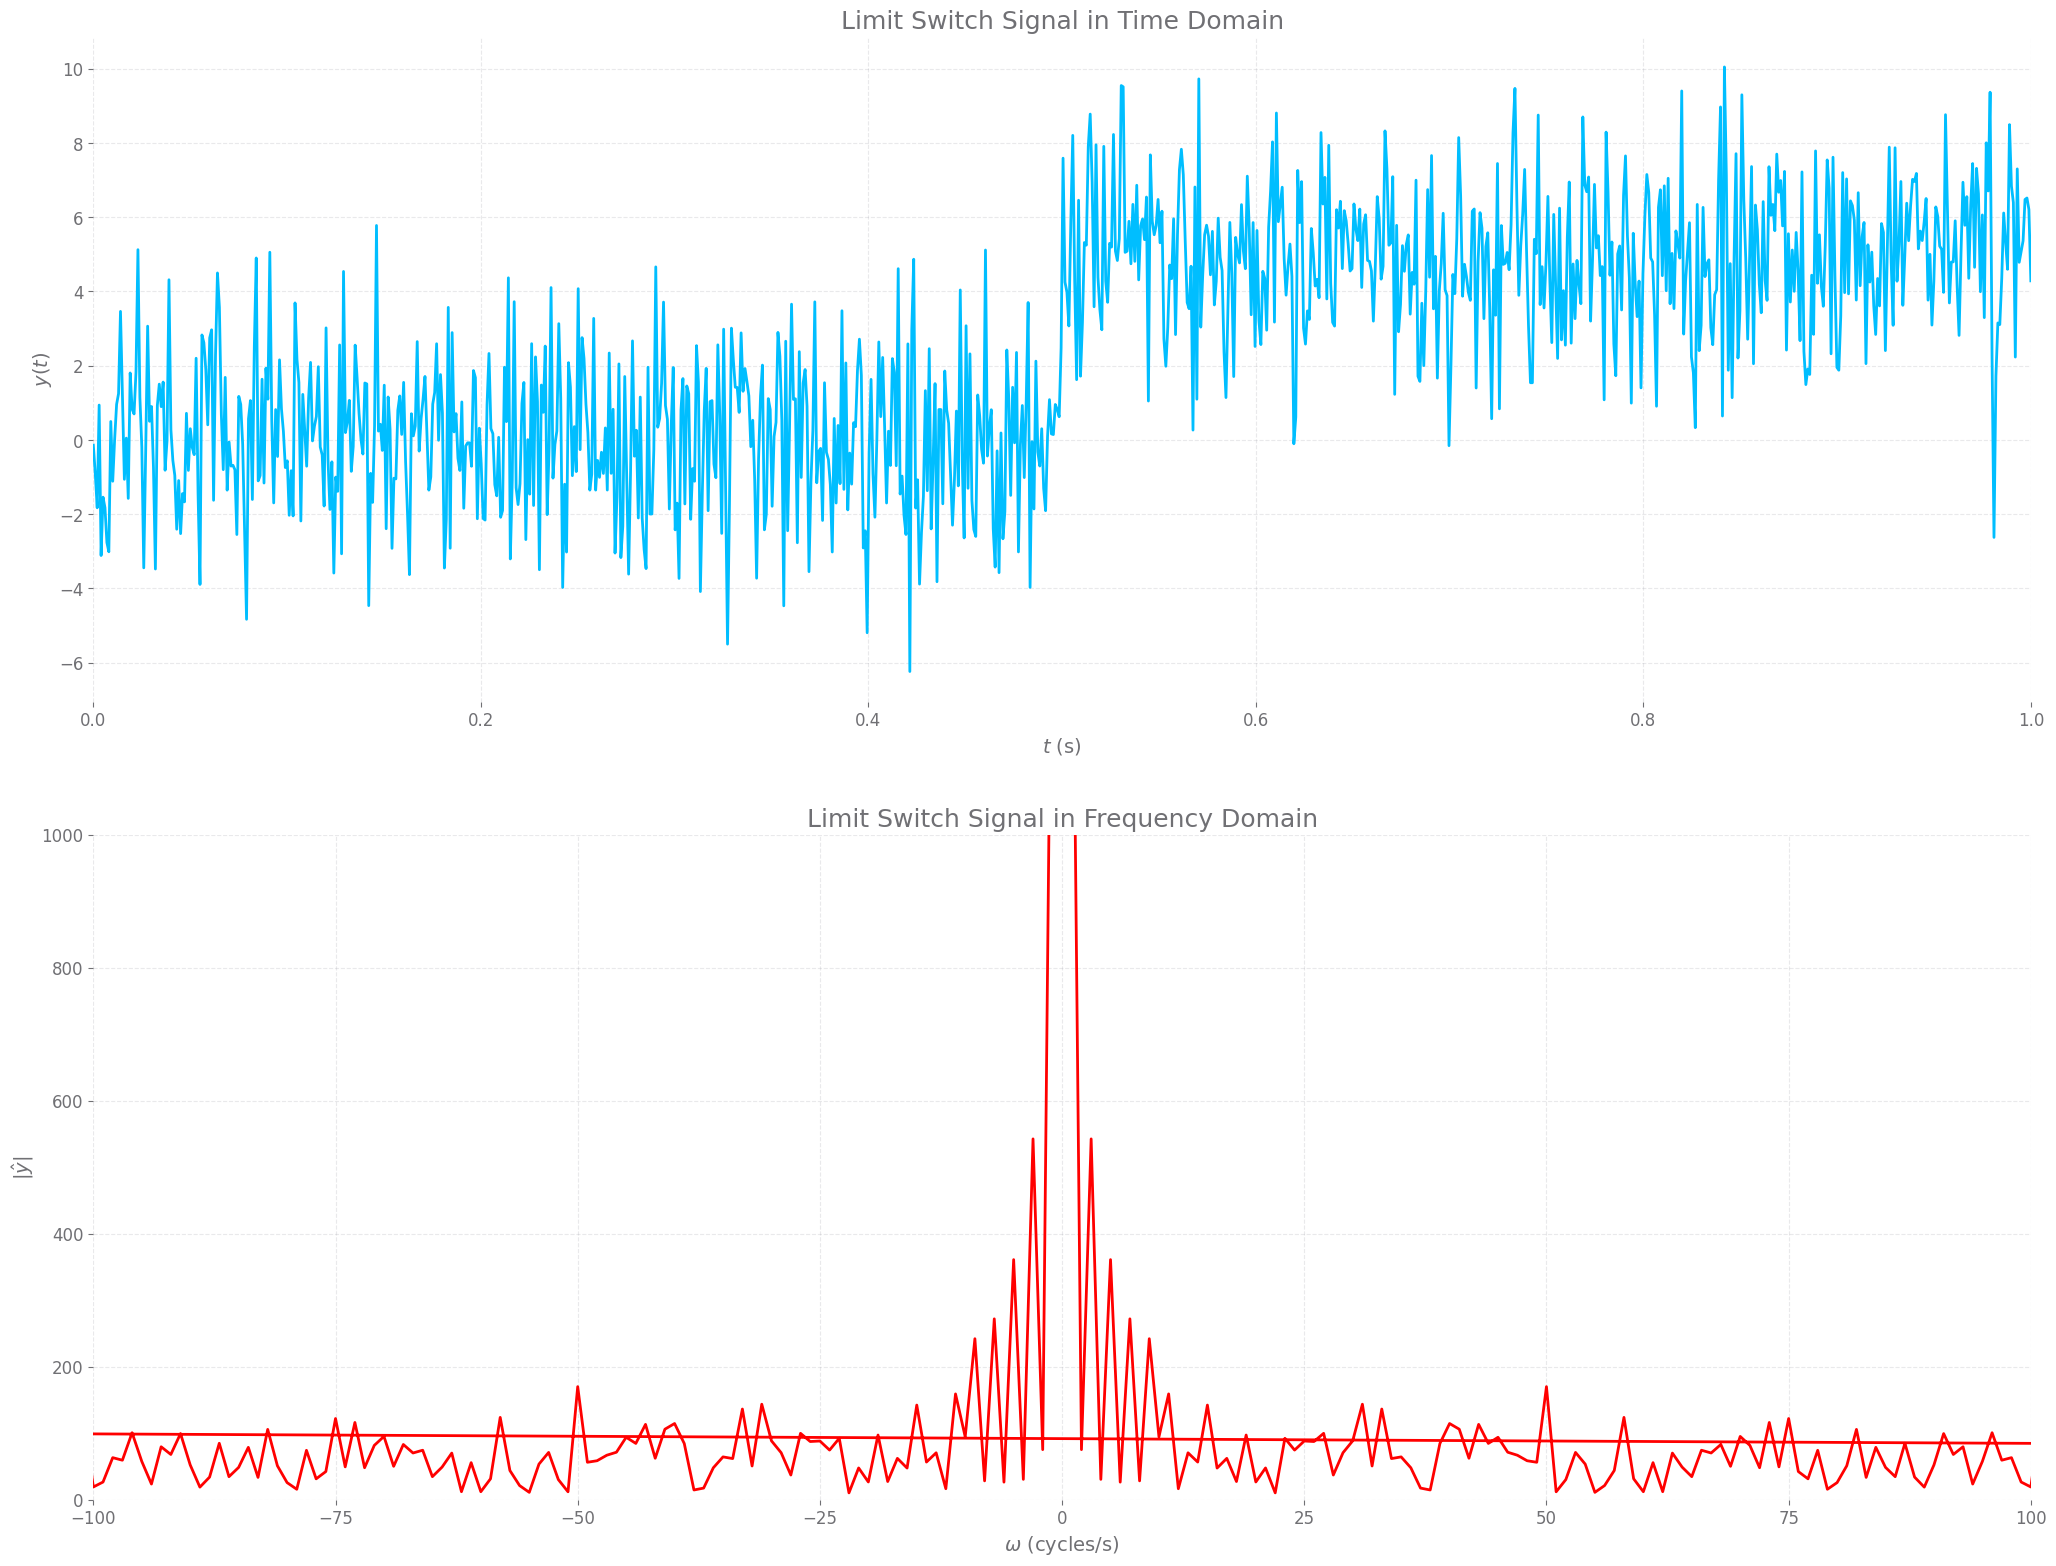

In [239]:
tlims = [0,1]        # in seconds
signalFreq = [2,50]; # Cycles / second
signalMag = [1,0.2]; # magnitude of each sine
t = np.linspace(tlims[0],tlims[1],(tlims[1]-tlims[0])*sampling_Freq)
y = np.array([ np.where(i<0.5, 0, 5) for i in t], dtype='float32')

# Add some noise
N = 2
n = np.random.randn(*y.shape) * N
spikes = n.copy()
for i in range(len(n)):
    if np.random.rand() > 0.9:
        pass
    else:
        spikes[i] = 0
        
y_noisy = y + n

# Compute the Fourier transform
yhat = np.fft.fft(y);
fcycles = np.fft.fftfreq(len(t), d=1.0/samplingFreq); # the frequencies in cycles/s

yhat_noisy = np.fft.fft(y_noisy);
fcycles = np.fft.fftfreq(len(t), d=1.0/samplingFreq); # the frequencies in cycles/s

# Plot the signal
fig, ax = plt.subplots(2, 1, figsize=(25,19))

ax[0].plot(t,y_noisy);
ax[0].set_title("Limit Switch Signal in Time Domain") 
ax[0].set_ylabel("$y(t)$");
ax[0].set_xlabel("$t$ (s)");
ax[0].set_xlim([min(t),max(t)]);

# Plot the power spectrum
ax[1].plot(fcycles,np.absolute(yhat_noisy), color='red');
ax[1].set_title("Limit Switch Signal in Frequency Domain") 
ax[1].set_xlim([-100,100]);
ax[1].set_ylim([0,1000]);
ax[1].set_xlabel("$\omega$ (cycles/s)");
ax[1].set_ylabel("$|\hat{y}|$");

### NOISY ENCODER SIGNAL

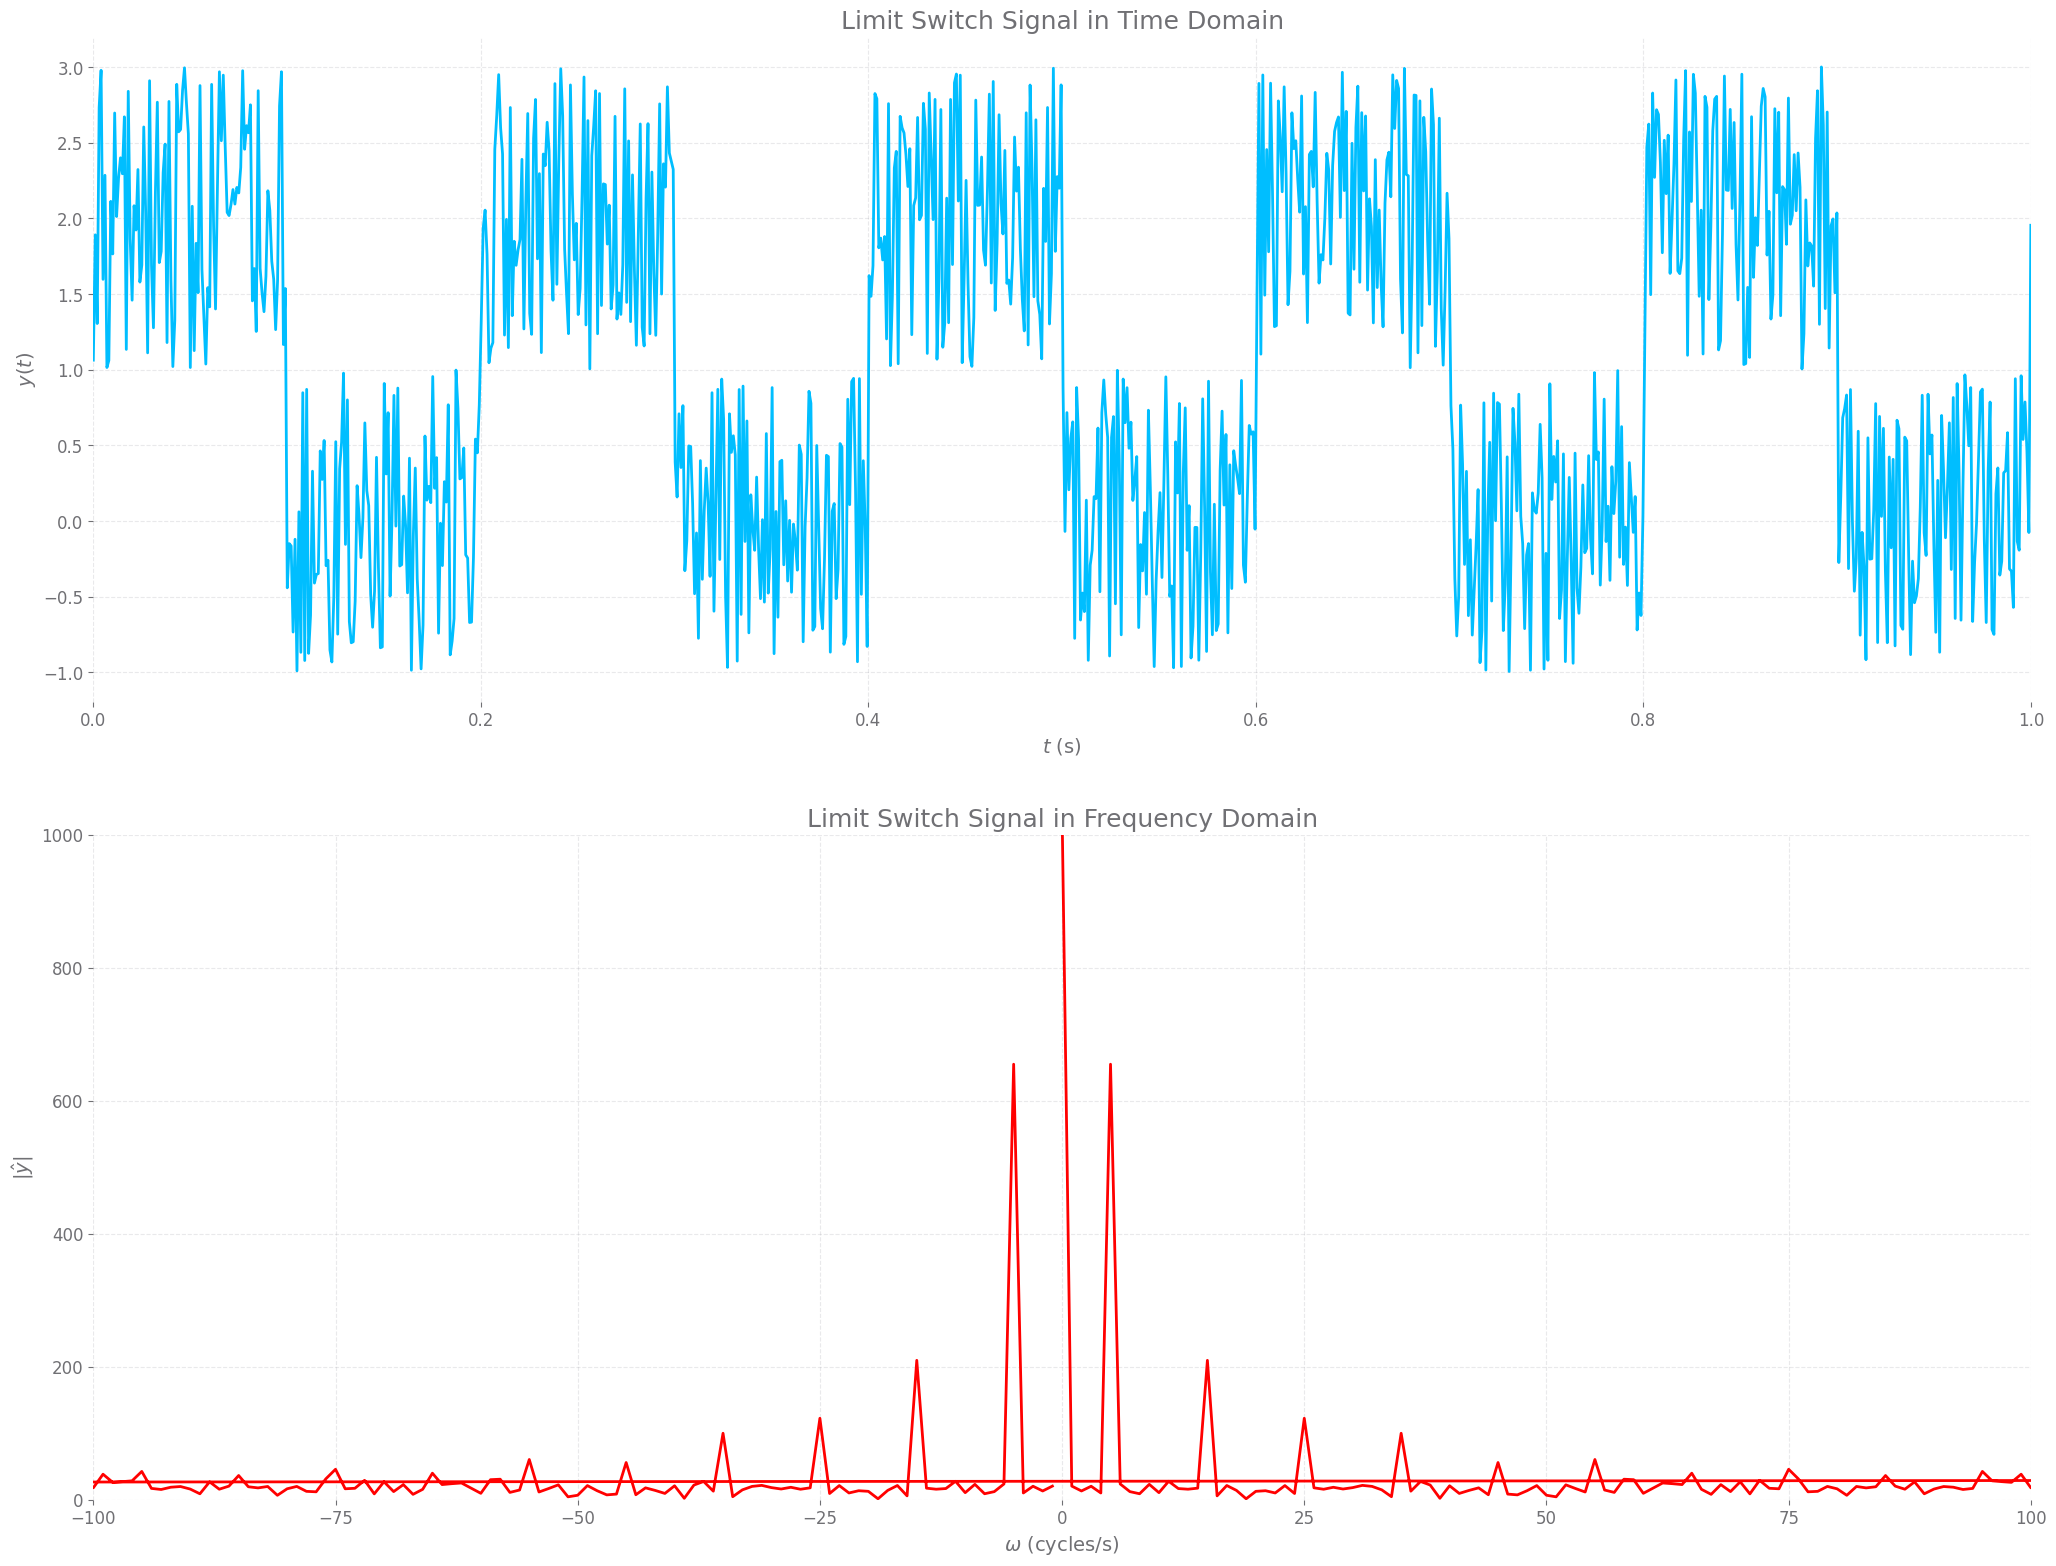

In [254]:
# Generate a signal
samplingFreq = 1000; # sampled at 1 kHz = 1000 samples / second
tlims = [0,1]        # in seconds
signalFreq = [2,50]; # Cycles / second
signalMag = [1,0.2]; # magnitude of each sine
t = np.linspace(tlims[0],tlims[1],(tlims[1]-tlims[0])*samplingFreq)
y = signal.square(2 * np.pi * 5 * t)


# Add some noise
N = 1
n = np.random.rand(*y.shape) * 2
y_noisy= y + n

# Compute the Fourier transform
yhat_noisy = np.fft.fft(y_noisy);
fcycles = np.fft.fftfreq(len(t),d=1.0/samplingFreq); # the frequencies in cycles/s

# Plot the signal
fig, ax = plt.subplots(2, 1, figsize=(25,19))

ax[0].plot(t,y_noisy);
ax[0].set_title("Limit Switch Signal in Time Domain") 
ax[0].set_ylabel("$y(t)$");
ax[0].set_xlabel("$t$ (s)");
ax[0].set_xlim([min(t),max(t)]);

# Plot the power spectrum
ax[1].plot(fcycles,np.absolute(yhat_noisy), color='red');
ax[1].set_title("Limit Switch Signal in Frequency Domain") 
ax[1].set_xlim([-100,100]);
ax[1].set_ylim([0,1000]);
ax[1].set_xlabel("$\omega$ (cycles/s)");
ax[1].set_ylabel("$|\hat{y}|$");

In [255]:
### GIVENS
Pulse_per_rotation = 100       # PPR
wheel_radius       = 0.1       # meter
max_speed          = 0.5       # m/s



rotation_per_sec   = 0.8      # RPS
Pulse_per_sec      = 80       # PPS

#### SIN WAVES

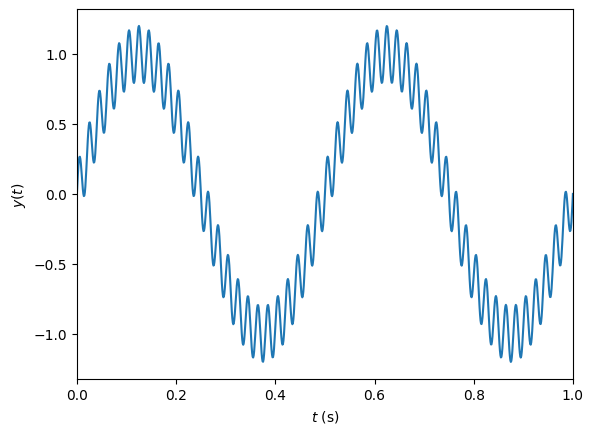

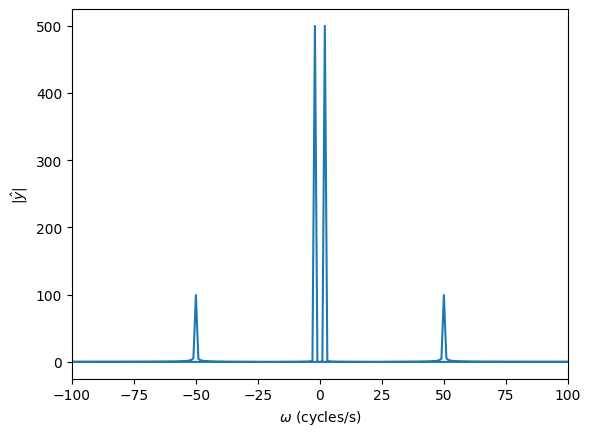

In [4]:
# Generate a signal
samplingFreq = 1000; # sampled at 1 kHz = 1000 samples / second
tlims = [0,1]        # in seconds
signalFreq = [2,50]; # Cycles / second
signalMag = [1,0.2]; # magnitude of each sine
t = np.linspace(tlims[0],tlims[1],(tlims[1]-tlims[0])*samplingFreq)
y = signalMag[0]*np.sin(2*math.pi*signalFreq[0]*t) + signalMag[1]*np.sin(2*math.pi*signalFreq[1]*t)

# Compute the Fourier transform
yhat = np.fft.fft(y);
fcycles = np.fft.fftfreq(len(t),d=1.0/samplingFreq); # the frequencies in cycles/s

# Plot the signal
plt.figure()
plt.plot(t,y);
plt.ylabel("$y(t)$");
plt.xlabel("$t$ (s)");
plt.xlim([min(t),max(t)]);

# Plot the power spectrum
plt.figure()
plt.plot(fcycles,np.absolute(yhat));
plt.xlim([-100,100]);
plt.xlabel("$\omega$ (cycles/s)");
plt.ylabel("$|\hat{y}|$");

## 2. Low-pass filter transfer function

* A cutoff frequency is selected and the transfer function for the low-pass filter is computed using <code>signal.TransferFunction</code>
* The low-pass filter transfer function is
$$H(s) = \frac{\omega_0}{s + \omega_0}$$
* The Bode plot shows the frequency response of $H$ by plotting the magnitude and phase of the frequency response
* Low frequencies are not attenuated (this is the *pass band*)
* High frequencies are attenutated (this is the *stop band*)


In [256]:
# Low-pass filter
critical_time = 2
cutoff_Freq   =80  # cut-off frequency
sampling_Freq = 1000; # sampled at 1 kHz = 1000 samples / second

w0 = 2 * np.pi * cutoff_Freq;                # pole frequency (rad/s)
num = w0                                     # transfer function numerator coefficients
den = [1,w0]                                 # transfer function denominator coefficients
lowPass = signal.TransferFunction(num, den)  # Transfer function


(-16.027380468628923, -2.7143320296785294e-05)

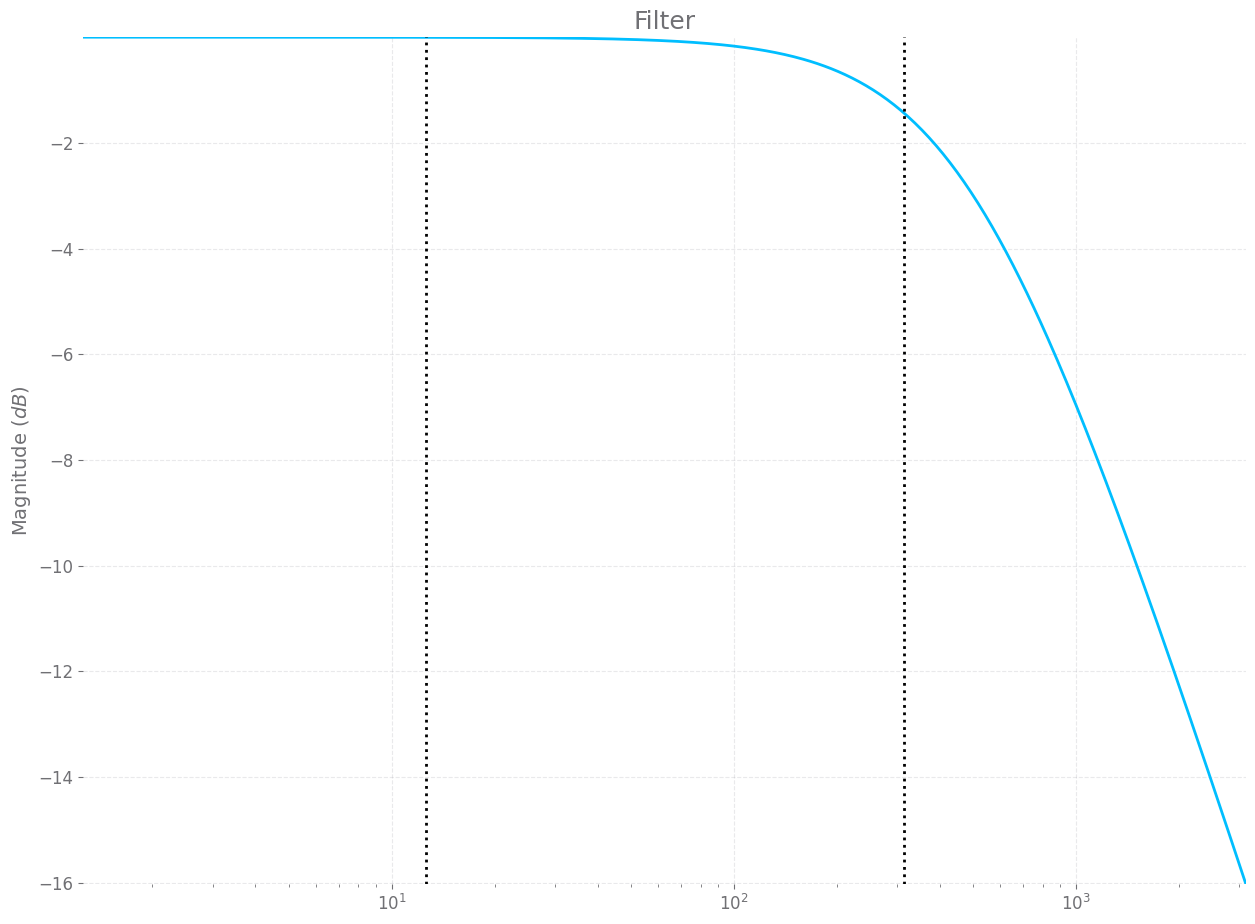

In [257]:
# Generate the bode plot
w = np.logspace( np.log10(min(signalFreq)*2*np.pi/10), np.log10(max(signalFreq)*2*np.pi*10), 500 )
w, mag, phase = signal.bode(lowPass,w)


# Magnitude plot
plt.figure(figsize=(15,11))
plt.semilogx(w, mag)
for sf in signalFreq:
    plt.semilogx([sf*2*np.pi,sf*2*np.pi],[min(mag),max(mag)],'k:')

plt.title("Filter")
plt.ylabel("Magnitude ($dB$)")
plt.xlim([min(w),max(w)])
plt.ylim([min(mag),max(mag)])


## 3. Discrete transfer function

To implement the low-pass filter on hardware, you need to compute the discrete transfer function using the signal's sampling frequency.
* The time step is $\Delta t = 1/f_s$
* Computing the discrete transfer function using Tustin's method, set $s = \frac{2}{\Delta t} \left( \frac{1-z^{-1}}{1+z^{-1}} \right)$, so
$$ H(z) = \frac{\omega_0}{\frac{2}{\Delta t} \frac{1-z^{-1}}{1+z^{-1}}  + \omega_0} = \frac{\Delta t \omega_0 (z+1)}{(\Delta t \omega_0 + 2)z + \Delta t \omega_0 - 2} $$
* You don't have to compute it by hand. The <code>to_discrete</code> method is used to compute the bilinear transform (Tustin's method)

In [258]:
dt = 1.0/sampling_Freq;
discreteLowPass = lowPass.to_discrete(dt, method='gbt' ,alpha=0.5)
print(discreteLowPass)

TransferFunctionDiscrete(
array([0.20084864, 0.20084864]),
array([ 1.        , -0.59830271]),
dt: 0.001
)


In [259]:
b = discreteLowPass.num;
a = -discreteLowPass.den;

print(f' b : {discreteLowPass.num}')
print(f' a : {-discreteLowPass.den}')

 b : [0.20084864 0.20084864]
 a : [-1.          0.59830271]


## 4. Filter coefficients

We want to find the filter coefficients for the discrete update:
$$y[n] = a_1 y[n-1] + a_2 y[n-2] + ... + b_0 x[n] + b_1 x[n-1] + ...$$

The coefficients can be taken directly from the discrete transfer function of the filter in the form:
$$H(z) = \frac{b_0 + b_1 z^{-1} + b_2 z^{-2} + \ldots}{1 - a_1 z^{-1} - a_2 z^{-2} + \ldots}$$

(This is a result of taking the Z-transform which is not shown here)

Compare this to a transfer function with coefficients
<code>
num = [b_0, b_1, b_2]
den = [1, a_1, a_2]
</code>
is 
$$H(z) = \frac{b_0 z^2 + b_1 z + b_2}{z^2 + a_1 z + a_2}$$
which is equivalent to
$$H(z) = \frac{b_0 + b_1 z^{-1} + b_2 z^{-2}}{1 + a_1 z^{-1} + a_2 z^{-2}}$$
So you can take the coefficients in the same order that they are defined in the numerator and denominator of the transfer function object. The only difference is that the **coefficients in the denominator need a negative sign**.

* To filter the signal, apply the filter using the discrete update
* The filtered signal and filtered signal power spectrum are plotted alongside the unfiltered signal

In [260]:
print(f' y[n] = {a[1]:.3} y[n-1] + {b[0]:.3} x[n] + {b[1]:.3} x[n-1]')

 y[n] = 0.598 y[n-1] + 0.201 x[n] + 0.201 x[n-1]


#### Real Time Implementation

In [261]:
# The coefficients from the discrete form of the filter transfer function (but with a negative sign)

print("Filter coefficients b_i: " + str(b))
print("Filter coefficients a_i: " + str(a[1:]))

# Filter the signal
yfilt = np.zeros(len(y));
for i in range(3,len(y)):
    yfilt[i] = a[1]*yfilt[i-1] + b[0]*y[i] + b[1]*y[i-1];

Filter coefficients b_i: [0.20084864 0.20084864]
Filter coefficients a_i: [0.59830271]


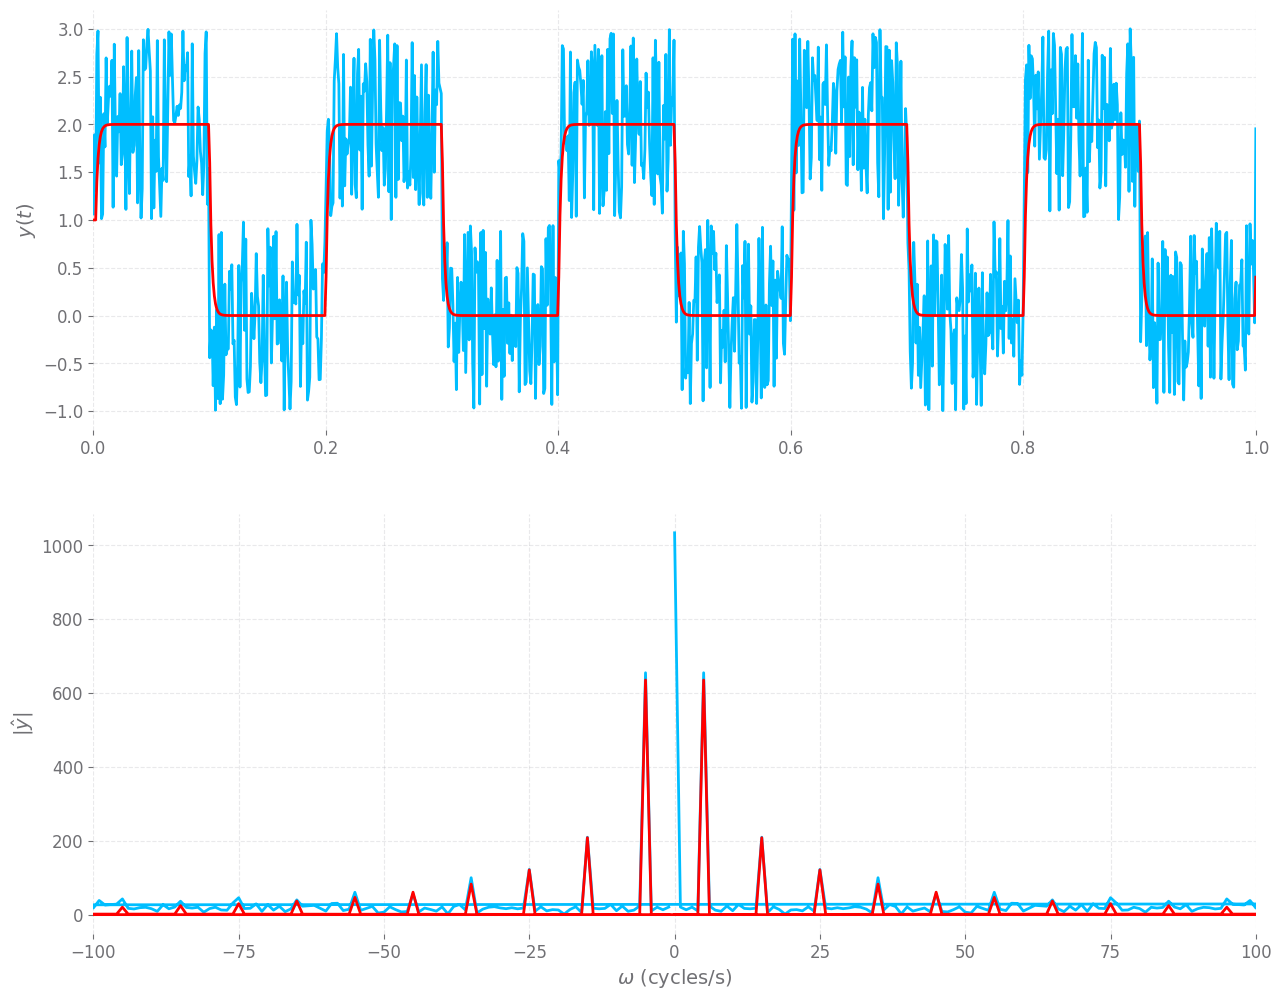

In [262]:
# Plot the signal
fig, ax = plt.subplots(2,1 , figsize=(15,12))
ax[0].plot(t,y_noisy);
ax[0].plot(t,yfilt+1, color='red');
ax[0].set_ylabel("$y(t)$")
ax[0].set_xlim([min(t),max(t)]);

# Generate Fourier transform
yfilthat = np.fft.fft(yfilt)
fcycles = np.fft.fftfreq(len(t),d=1.0/samplingFreq)

ax[1].plot(fcycles,np.absolute(yhat_noisy));
ax[1].plot(fcycles,np.absolute(yfilthat), color='red');
ax[1].set_xlim([-100,100]);
ax[1].set_xlabel("$\omega$ (cycles/s)");
ax[1].set_ylabel("$|\hat{y}|$");


$$y[n] = a_1 y[n-1] + a_2 y[n-2] + ... + b_0 x[n] + b_1 x[n-1] + ...$$
